# Closed-loop experimentation with active learning

In this tutorial, you'll learn how to implement a complete closed-loop experiment using the AutoRA framework. 

In traditional active learning, we typically have a fixed pool of unlabeled data (e.g., images) that we want to label efficiently by selecting the most informative samples. In experimental design, however, we don't have a pre-existing pool of conditions - instead, we can **generate new experimental conditions on the fly** and collect observations from participants.

This leads us to **closed-loop experimentation**, where:
1. An **experimentalist** proposes new experimental conditions
2. An **experiment runner** collects observations at those conditions
3. A **theorist** (model) learns from the accumulated data
4. The cycle repeats, with the experimentalist using the current model to propose even better conditions

The AutoRA framework connects these three components:

![static/img/autora_workflow.png](static/img/autora_workflow.png)

(Image source: [autora](https://autoresearch.github.io/autora/))

In this tutorial, you will learn to:
- Set up the AutoRA experiment runner for the 2AFC task
- Implement a cyclic for-loop for closed-loop experimentation
- Collect data iteratively and fit models at each cycle
- Track model performance across cycles
- Understand how to integrate different experimentalist strategies

Let's get started!

## Library imports

In [1]:
import sys, os

import numpy as np
import pandas as pd

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)
    
from resources.regressors import FFN, FFNRegressor

## Setting up the synthetic experiment

First, let's set up our synthetic 2AFC experiment with multiple synthetic participants. Each participant has their own cognitive model parameters that determine how they respond to different experimental conditions.

In [2]:
# Basic experiment parameters

n_units = 100  # Number of synthetic participants
noise_level = 0.  # Measurement noise level

# Sample parameters for each synthetic participant
# Each participant has 2 parameters controlling their sensitivity to ratio and scatteredness
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0.1, parameters)  # Ensure positive parameters

print(f"Created {n_units} synthetic participants with individual cognitive parameters")
print(f"Example participant parameters: {parameters[0]}")

Created 100 synthetic participants with individual cognitive parameters
Example participant parameters: [1.9526481  1.03238573]


## Introduction to the AutoRA experiment runner

The AutoRA experiment runner is a wrapper around our 2AFC experiment that:
- Defines the **independent variables** (conditions we can control): participant_id, ratio, scatteredness
- Defines the **dependent variables** (observations we measure): response_time
- Provides a standardized interface for running experiments

Think of it as a way to package our experiment so it can be easily integrated into the closed-loop workflow.

Let's import and explore the experiment runner:

In [3]:
from resources.synthetic import twoafc

# Check the help documentation
help(twoafc)

Help on function twoafc in module resources.synthetic:

twoafc(parameters: numpy.ndarray, name='2AFC', resolution=100, minimum_value_condition: float = 0.0, maximum_value_condition: float = 1.0, noise_level: float = 0.0, discrete_iv: bool = False)
    2AFC experiment with two independent variables
    
    Args:
        parameters: abstract participant parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393



In [4]:
from autora.experiment_runner.synthetic.utilities import describe

# Create the experiment runner with our synthetic participants
experiment = twoafc(parameters=parameters, noise_level=noise_level)

# Describe the experiment structure
print(describe(experiment))


    2AFC experiment with two independent variables

    Args:
        parameters: abstract participant parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393
    


The experiment runner has two key methods:
- `experiment.run(conditions)`: Runs the experiment on specified conditions and returns observations
- `experiment.plotter()`: Visualizes the ground truth cognitive model and fitted model predictions

Let's test it by running a single condition:

Experiment result:
    unit_id  ratio  scatteredness  response_time
0         0      1              1       1.400779
1         1      1              1       1.571074
2         2      1              1       2.000000
3         3      1              1       1.544133
4         4      1              1       1.552155
..      ...    ...            ...            ...
95       95      1              1       1.817166
96       96      1              1       1.597313
97       97      1              1       1.570404
98       98      1              1       1.489800
99       99      1              1       1.577320

[100 rows x 4 columns]


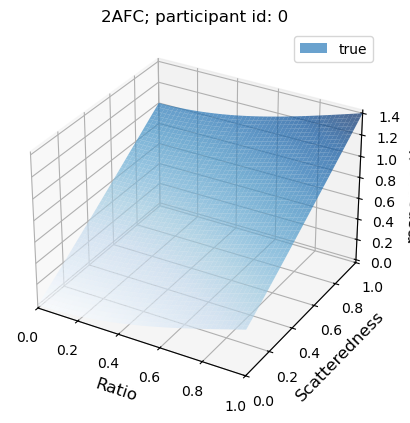

In [5]:
# Run the experiment on a single condition: [participant_id=0, ratio=1, scatteredness=1]
result = experiment.run(np.array([[1, 1]]), random_state=42)
print("Experiment result:")
print(result)

# Visualize the underlying ground truth for participant 0
experiment.plotter(participant_id=0)

## Setting up the closed-loop components

Now let's set up the three key components of our closed-loop experiment:

1. **Experiment runner**: We've already created this above (`experiment`)
2. **Experimentalist**: Proposes new experimental conditions to test
3. **Theorist**: A machine learning model that learns from the data

For the experimentalist, we'll start with a simple **random sampling** strategy that uniformly samples conditions from the experimental space.

In [6]:
from autora.experimentalist.random import random_pool

# Define the experimentalist (random sampling strategy)
experimentalist = random_pool

# Define the theorist (neural network model)
theorist = FFNRegressor(
    FFN(n_units=n_units, n_conditions=2),  # n_conditions=2 for ratio and scatteredness
    max_epochs=100,
    lr=0.1
)

print("Closed-loop components initialized:")
print(f"  Experiment: 2AFC task with {n_units} participants")
print(f"  Experimentalist: Random sampling")
print(f"  Theorist: Feed-forward neural network")

Closed-loop components initialized:
  Experiment: 2AFC task with 100 participants
  Experimentalist: Random sampling
  Theorist: Feed-forward neural network


## Understanding the variable structure

Before we start the loop, let's understand how the experiment variables are structured:

In [7]:
# Extract variable names from the experiment
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

print("Independent variables (conditions):", iv_names)
print("Dependent variables (observations):", dv_names)

Independent variables (conditions): ['ratio', 'scatteredness']
Dependent variables (observations): ['response_time']


## Generating initial conditions

Every closed-loop experiment needs some initial conditions to start with. We'll use the experimentalist to generate an initial set of random conditions:

In [8]:
# Generate initial random conditions
n_samples = 100  # Number of conditions to sample per cycle

conditions = experimentalist(experiment.variables, n_samples).to_numpy()

print(f"Generated {len(conditions)} initial conditions")
print(f"Condition shape: {conditions.shape}")
print(f"First few conditions:")
print(conditions[:5])

Generated 100 initial conditions
Condition shape: (100, 2)
First few conditions:
[[0.61468808 0.5283698 ]
 [0.18659749 0.87083255]
 [0.43974169 0.36609427]
 [0.17482161 0.94343722]
 [0.71112122 0.46516393]]


## The closed-loop experimentation cycle

Now we're ready to implement the main closed-loop! 

Here's how each cycle works:

1. **Run experiment**: Collect observations at the current conditions
2. **Split data**: Divide into training and test sets
3. **Fit model**: Train the theorist on the training data
4. **Evaluate**: Test the model on held-out data
5. **Generate new conditions**: Use the experimentalist to propose new conditions
6. **Accumulate**: Add new conditions to the pool for the next cycle

This creates a **cyclic for-loop** where we continuously improve our model by collecting more data and refining our understanding.

Let's implement this:

In [10]:
# Closed-loop parameters
n_cycles = 1  # Number of cycles to run
train_ratio = 0.8  # Proportion of data to use for training (80% train, 20% test)

# Start the closed-loop experimentation cycle
for cycle in range(n_cycles):
    
    # Step 1: Run the experiment on current conditions
    experiment_data = experiment.run(conditions, shuffle=True).to_numpy()
    
    # Step 2: Split data into training and test sets
    n_train = int(experiment_data.shape[0] * train_ratio)
    experiment_data_train = experiment_data[:n_train]
    experiment_data_test = experiment_data[n_train:]
    
    # Step 3: Fit the theorist on training data
    # X = conditions (participant_id, ratio, scatteredness)
    # y = observations (response_time)
    n_dv = len(experiment.variables.dependent_variables)
    X_train = experiment_data_train[:, :-n_dv]
    y_train = experiment_data_train[:, -n_dv:]
    
    theorist.fit(X=X_train, y=y_train)
    
    # Step 4: Evaluate the theorist on test data
    X_test = experiment_data_test[:, :-n_dv]
    y_test = experiment_data_test[:, -n_dv:]
    
    y_predicted = theorist.predict(X_test)
    mse = np.mean((y_test - y_predicted)**2)
    
    # Step 5: Generate new conditions for the next cycle
    new_conditions = experimentalist(experiment.variables, n_samples).to_numpy()
    
    # Step 6: Accumulate conditions for the next cycle
    conditions = np.concatenate((conditions, new_conditions))
    
    # Print progress
    print(f"Cycle {cycle+1}/{n_cycles}: Test MSE = {np.round(mse, 8)}")

print(f"\nClosed-loop completed! Total conditions tested: {len(conditions)}")


epoch	train loss
1/100	0.33936530
2/100	0.09927925
3/100	0.05094660
4/100	0.02885921
5/100	0.01516575
6/100	0.01072478
7/100	0.00936686
8/100	0.00838162
9/100	0.00769382
10/100	0.00710411
11/100	0.00682446
12/100	0.00647959
13/100	0.00635556
14/100	0.00606051
15/100	0.00580624
16/100	0.00587497
17/100	0.00584181
18/100	0.00569926
19/100	0.00569712
20/100	0.00586005
21/100	0.00554583
22/100	0.00530939
23/100	0.00511214
24/100	0.00517372
25/100	0.00510000
26/100	0.00491063
27/100	0.00467050
28/100	0.00453430
29/100	0.00448061
30/100	0.00439284
31/100	0.00442189
32/100	0.00442153
33/100	0.00455624
34/100	0.00449090
35/100	0.00449375
36/100	0.00422492
37/100	0.00401856
38/100	0.00403528
39/100	0.00405950
40/100	0.00392835
41/100	0.00393134
42/100	0.00394059
43/100	0.00389773
44/100	0.00416232
45/100	0.00392753
46/100	0.00398838
47/100	0.00420946
48/100	0.00430577
49/100	0.00406088
50/100	0.00396059
51/100	0.00378319
52/100	0.00387330
53/100	0.00381060
54/100	0.00414239
55/100	0.00395865
5

## Visualizing the results

Now let's visualize how well our trained model recovered the underlying cognitive model for a specific participant:

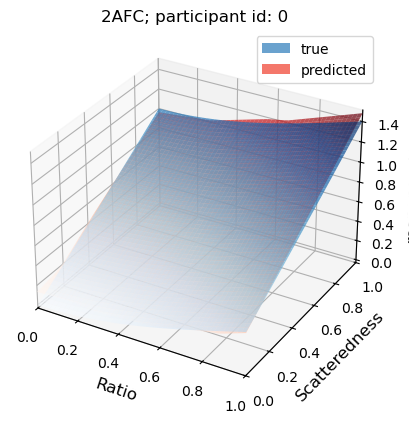

In [11]:
# Visualize the ground truth and model predictions for participant 0
experiment.plotter(
    participant_id=0,
    model=theorist,
)

The plot shows:
- **Blue surface**: The true underlying cognitive model
- **Red surface**: The neural network's learned predictions

How well does the model capture the true pattern? Try:
- Increasing `n_cycles` to see if more cycles improve the fit
- Changing `n_samples` to collect more/fewer conditions per cycle
- Adding noise by setting `noise_level > 0` at the beginning
- Testing different participants by changing `participant_id`

## Understanding the cyclic for-loop

The key advantage of this cyclic approach is its simplicity and transparency:

```python
for cycle in range(n_cycles):
    1. Run experiment on current conditions
    2. Split into train/test
    3. Fit model on training data
    4. Evaluate on test data
    5. Generate new conditions
    6. Accumulate conditions
```

Each step is explicit and easy to understand. You can:
- Add custom logging or visualization at any step
- Modify the data processing pipeline
- Integrate different experimentalist strategies
- Track additional metrics

This makes it perfect for learning and experimentation!

## Experimenting with different experimentalists

So far, we've used random sampling to propose new conditions. But AutoRA provides also other experimentalists like the **grid sampler**.

You can install them with:
```bash
pip install -U "autora[all-experimentalists]"
```

Or install specific ones:
```bash
pip install -U "autora[experimentalist-grid]"
```

Let's try using the **grid sampler** instead of random sampling:

In [14]:
from autora.experimentalist.grid import grid_pool

# Reset the experiment and theorist
experiment = twoafc(parameters, noise_level=noise_level, discrete_iv=True, resolution=10)
theorist = FFNRegressor(FFN(n_units=n_units, n_conditions=2), max_epochs=100, lr=0.1)

# Use grid sampling instead of random sampling
experimentalist = grid_pool

# Generate initial grid conditions
conditions = experimentalist(experiment.variables).to_numpy()

print(f"Using grid sampling strategy")
print(f"First few grid conditions:")
print(conditions[:5])

Using grid sampling strategy
First few grid conditions:
[[0.         0.        ]
 [0.         0.11111111]
 [0.         0.22222222]
 [0.         0.33333333]
 [0.         0.44444444]]



epoch	train loss
1/100	0.25808570
2/100	0.07164996
3/100	0.03851195
4/100	0.02213126
5/100	0.01528920
6/100	0.01328117
7/100	0.01117427
8/100	0.00993245
9/100	0.00942339
10/100	0.00878693
11/100	0.00848801
12/100	0.00809609
13/100	0.00776035
14/100	0.00739442
15/100	0.00706642
16/100	0.00670469
17/100	0.00641154
18/100	0.00643799
19/100	0.00585120
20/100	0.00565381
21/100	0.00539614
22/100	0.00504988
23/100	0.00467050
24/100	0.00459422
25/100	0.00473819
26/100	0.00466159
27/100	0.00433684
28/100	0.00423885
29/100	0.00402801
30/100	0.00400977
31/100	0.00376790
32/100	0.00373485
33/100	0.00367443
34/100	0.00357714
35/100	0.00353266
36/100	0.00347741
37/100	0.00344112
38/100	0.00357534
39/100	0.00341209
40/100	0.00337159
41/100	0.00343209
42/100	0.00310539
43/100	0.00312419
44/100	0.00288163
45/100	0.00306213
46/100	0.00292425
47/100	0.00292231
48/100	0.00262160
49/100	0.00261015
50/100	0.00238282
51/100	0.00229931
52/100	0.00235230
53/100	0.00222998
54/100	0.00230655
55/100	0.00214841
5

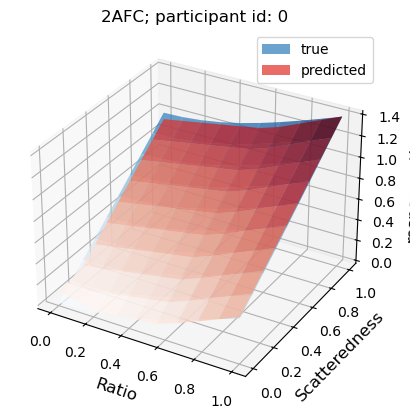

In [16]:
# Run the same closed-loop with grid sampling
for cycle in range(n_cycles):
    experiment_data = experiment.run(conditions, shuffle=True).to_numpy()
    
    n_train = int(experiment_data.shape[0] * train_ratio)
    experiment_data_train = experiment_data[:n_train]
    experiment_data_test = experiment_data[n_train:]
    
    n_dv = len(experiment.variables.dependent_variables)
    X_train = experiment_data_train[:, :-n_dv]
    y_train = experiment_data_train[:, -n_dv:]
    
    theorist.fit(X=X_train, y=y_train)
    
    X_test = experiment_data_test[:, :-n_dv]
    y_test = experiment_data_test[:, -n_dv:]
    
    y_predicted = theorist.predict(X_test)
    mse = np.mean((y_test - y_predicted)**2)
    
    new_conditions = experimentalist(experiment.variables).to_numpy()
    conditions = np.concatenate((conditions, new_conditions))
    
    print(f"Cycle {cycle+1}/{n_cycles} [Grid Sampling]: Test MSE = {np.round(mse, 8)}")

# Visualize results
experiment.plotter(participant_id=0, model=theorist)

Notice any differences between random and grid sampling?

Grid sampling provides more systematic coverage of the experimental space, which can be beneficial when you want to ensure even sampling across all regions.

## Congratulations!

You have completed all tutorials in the **Optimizing Experimental Design Course**! 

You've learned:
- How to set up synthetic experiments with cognitive models
- How to implement closed-loop experimentation with AutoRA
- How to integrate different experimentalist strategies
- How to evaluate model performance across cycles

AutoRA comes with many more sophisticated experimentalists:

- **Random**: Uniform random sampling (what we used)
- **Grid**: Systematic grid sampling
- **Novelty**: Samples conditions far from previous conditions
- **Inequality**: Samples where model predictions vary most
- **Nearest Value**: Samples near specific target values
- **Disagreement**: Samples where ensemble models disagree (requires ensemble)
- **Uncertainty**: Samples where model is most uncertain (requires ensemble)
- **Leverage**: Samples with high influence on model parameters
- **Falsification**: Samples likely to falsify current theory
- **Mixture**: Combines multiple strategies

In the next tutorials we are going to learn more about the **Uncertainty** and **Disagreement samplers**